c:\Users\ADMIN\miniconda3\envs\astro_env\lib\site-packages\skimage\registration\_phase_cross_correlation.py:119: RuntimeWarning: overflow encountered in scalar multiply
  amp = src_amp * target_amp
Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\ADMIN\miniconda3\envs\astro_env\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "c:\Users\ADMIN\miniconda3\envs\astro_env\lib\tkinter\__init__.py", line 839, in callit
    func(*args)
  File "C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21380\3586588065.py", line 1159, in _show_all_results_windows
    self._create_or_update_main_result_window()
  File "C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21380\3586588065.py", line 1264, in _create_or_update_main_result_window
    self.main_result_window.title(f"Nhóm '{current_seq_id}': Bản Đồ Độ Phân Cực & Góc Phân Cực")
  File "c:\Users\ADMIN\miniconda3\envs\astro_env\lib\tkinter\__init__.py", line 2255, in wm_title
    return self.tk

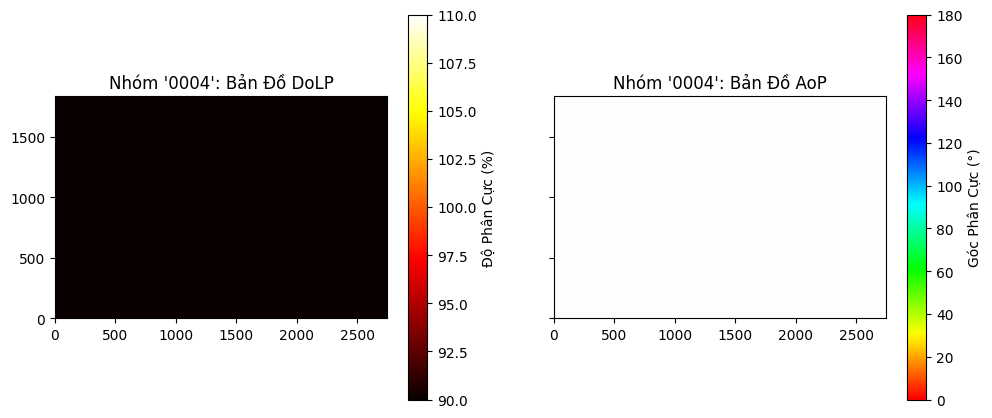

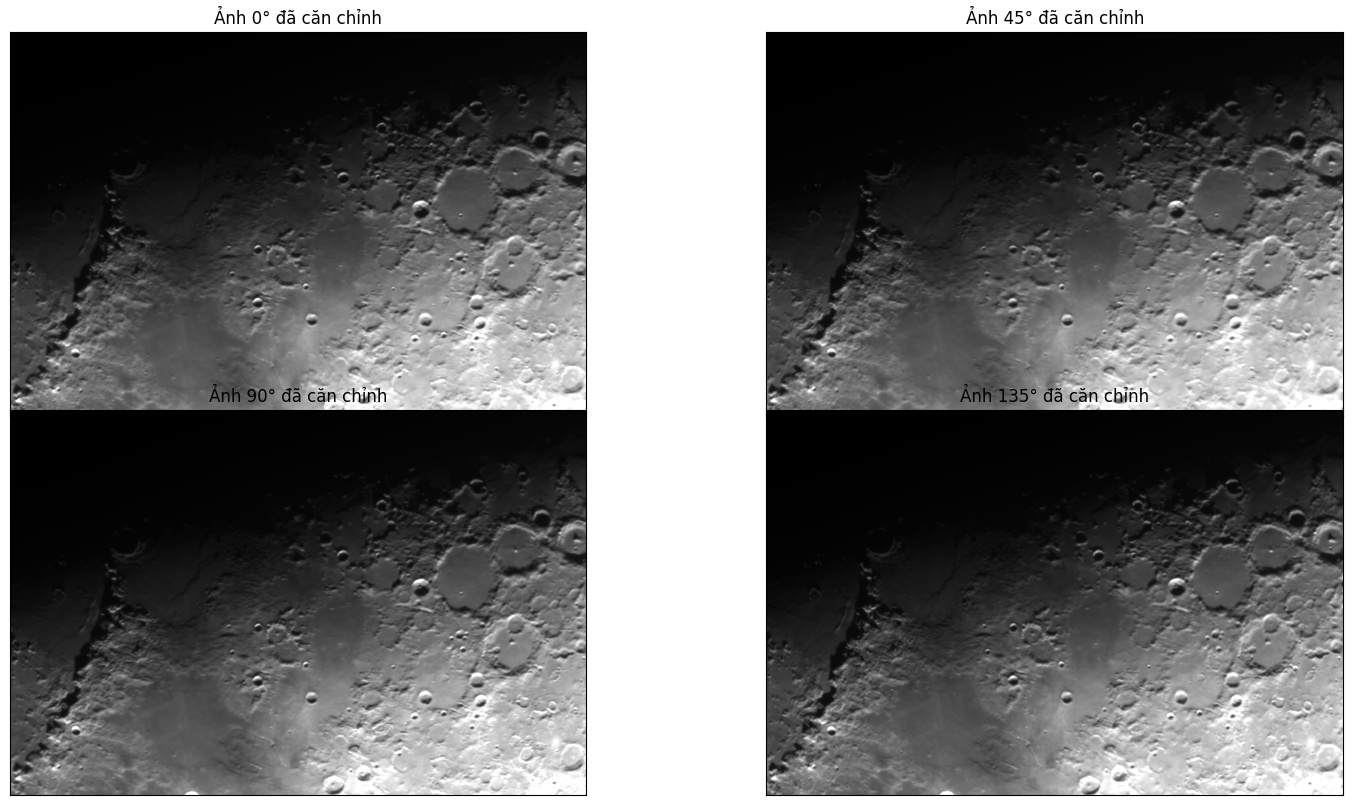

In [ ]:
#!/usr/bin/env python3
"""
Polarization Image Processing Notebook
Xử lý ảnh phân cực

This notebook provides an interactive interface to:
1. Select a folder containing polarization FITS files
2. Process 4 polarization images (0°, 45°, 90°, 135°)
3. Calculate Stokes parameters and create polarization maps
4. Generate visualizations and save results

Notebook này cung cấp giao diện tương tác để:
1. Chọn thư mục chứa các tệp FITS phân cực
2. Xử lý 4 hình ảnh phân cực (0°, 45°, 90°, 135°)
3. Tính toán tham số Stokes và tạo bản đồ phân cực
4. Tạo hình ảnh trực quan và lưu kết quả
"""

# Import required libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import glob
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS
import warnings
import tkinter as tk
from tkinter import filedialog, messagebox
from IPython.display import display, clear_output
import ipywidgets as widgets

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)

print("=" * 60)
print("Polarization Image Processing / Xử lý ảnh phân cực")
print("=" * 60)
print("Libraries imported successfully / Các thư viện đã được import thành công")
print("Ready to start analysis / Sẵn sàng bắt đầu phân tích")
print("=" * 60)

In [ ]:
class PolarizationAnalyzer:
    """
    Class to handle polarization analysis of astronomical FITS data.
    Lớp xử lý phân tích phân cực dữ liệu FITS thiên văn.
    """
    
    def __init__(self, folder_path='.'):
        """
        Initialize the polarization analyzer.
        Khởi tạo bộ phân tích phân cực.
        
        Parameters / Tham số:
        -----------
        folder_path : str
            Path to the folder containing FITS files
            Đường dẫn đến thư mục chứa các tệp FITS
        """
        self.folder_path = folder_path
        self.fits_files = []
        self.data = {}
        self.headers = {}
        self.wcs = None
        
    def find_fits_files(self):
        """Find all FITS files in the specified folder."""
        patterns = ['*.fit', '*.fits', '*.fts']
        self.fits_files = []
        
        for pattern in patterns:
            files = glob.glob(os.path.join(self.folder_path, pattern))
            self.fits_files.extend(files)
        
        self.fits_files.sort()  # Sort for consistent ordering
        
        if len(self.fits_files) == 0:
            raise FileNotFoundError(f"No FITS files found in {self.folder_path}")
        
        print(f"Found {len(self.fits_files)} FITS files:")
        for i, file in enumerate(self.fits_files):
            print(f"  {i+1}: {os.path.basename(file)}")
            
        return self.fits_files
    
    def load_fits_data(self, max_files=4):
        """
        Load FITS data from files.
        Tải dữ liệu FITS từ các tệp.
        
        Parameters / Tham số:
        -----------
        max_files : int
            Maximum number of files to load (default: 4 for Stokes I, Q, U, V)
            Số lượng tệp tối đa để tải (mặc định: 4 cho Stokes I, Q, U, V)
        """
        if not self.fits_files:
            self.find_fits_files()
        
        # Use up to max_files
        files_to_load = self.fits_files[:max_files]
        
        print(f"\nLoading {len(files_to_load)} FITS files...")
        print(f"Đang tải {len(files_to_load)} tệp FITS...")
        
        for i, file_path in enumerate(files_to_load):
            try:
                with fits.open(file_path) as hdul:
                    # Get the primary HDU or first image HDU
                    for hdu in hdul:
                        if hdu.data is not None:
                            self.data[f'image_{i}'] = hdu.data.astype(np.float64)
                            self.headers[f'image_{i}'] = hdu.header
                            
                            # Store WCS information from first file
                            if self.wcs is None:
                                try:
                                    self.wcs = WCS(hdu.header)
                                except:
                                    print(f"Warning: Could not parse WCS from {file_path}")
                            break
                
                print(f"  ✓ Loaded: {os.path.basename(file_path)} - Shape: {self.data[f'image_{i}'].shape}")
                
            except Exception as e:
                print(f"❌ Error loading {file_path}: {str(e)}")
                continue
        
        if len(self.data) == 0:
            raise ValueError("No valid FITS data could be loaded")
            
        print(f"✅ Successfully loaded {len(self.data)} images")
        print(f"✅ Đã tải thành công {len(self.data)} hình ảnh")

print("PolarizationAnalyzer class defined / Lớp PolarizationAnalyzer đã được định nghĩa")

In [ ]:
    def calculate_stokes_parameters(self):
        """
        Calculate Stokes parameters from the loaded images.
        Tính toán các tham số Stokes từ hình ảnh đã tải.
        
        Assumes the first 4 images correspond to different polarization states.
        Giả định 4 hình ảnh đầu tiên tương ứng với các trạng thái phân cực khác nhau.
        """
        if len(self.data) < 2:
            raise ValueError("Need at least 2 images for polarization analysis")
        
        # Get image data
        images = [self.data[f'image_{i}'] for i in range(min(4, len(self.data)))]
        
        # Ensure all images have the same shape
        shapes = [img.shape for img in images]
        if not all(shape == shapes[0] for shape in shapes):
            print("Warning: Images have different shapes. Will crop to minimum dimensions.")
            print("Cảnh báo: Các hình ảnh có kích thước khác nhau. Sẽ cắt về kích thước tối thiểu.")
            min_shape = tuple(min(dim) for dim in zip(*shapes))
            images = [img[:min_shape[0], :min_shape[1]] for img in images]
        
        # Calculate Stokes parameters based on polarization angles
        # Tính toán tham số Stokes dựa trên góc phân cực
        if len(images) == 4:
            # Standard approach for 4 polarization angles: 0°, 45°, 90°, 135°
            I_0 = images[0]    # 0° polarization
            I_45 = images[1]   # 45° polarization  
            I_90 = images[2]   # 90° polarization
            I_135 = images[3]  # 135° polarization
            
            # Calculate Stokes parameters
            self.stokes_I = (I_0 + I_45 + I_90 + I_135) / 2  # Total intensity
            self.stokes_Q = I_0 - I_90                        # Linear polarization (0° - 90°)
            self.stokes_U = I_45 - I_135                      # Linear polarization (45° - 135°)
            self.stokes_V = np.zeros_like(self.stokes_I)      # Circular polarization (usually 0 for linear)
            
        elif len(images) == 3:
            # Three images: use first three
            self.stokes_I = images[0]
            self.stokes_Q = images[1] - images[2]
            self.stokes_U = images[2] - images[0]
            self.stokes_V = np.zeros_like(self.stokes_I)
            
        elif len(images) == 2:
            # Two images: simple difference
            self.stokes_I = (images[0] + images[1]) / 2
            self.stokes_Q = images[0] - images[1]
            self.stokes_U = np.zeros_like(self.stokes_I)
            self.stokes_V = np.zeros_like(self.stokes_I)
        
        # Calculate derived parameters / Tính toán các tham số dẫn xuất
        self.linear_polarization = np.sqrt(self.stokes_Q**2 + self.stokes_U**2)
        self.total_polarization = np.sqrt(self.stokes_Q**2 + self.stokes_U**2 + self.stokes_V**2)
        
        # Polarization angle (in degrees) / Góc phân cực (theo độ)
        self.polarization_angle = 0.5 * np.arctan2(self.stokes_U, self.stokes_Q) * 180 / np.pi
        
        # Polarization fraction / Tỷ lệ phân cực
        with np.errstate(divide='ignore', invalid='ignore'):
            self.polarization_fraction = self.linear_polarization / np.abs(self.stokes_I)
            self.polarization_fraction[self.stokes_I == 0] = 0
            self.polarization_fraction = np.clip(self.polarization_fraction, 0, 1)
        
        print("✅ Calculated Stokes parameters and polarization properties")
        print("✅ Đã tính toán tham số Stokes và thuộc tính phân cực")
        
        # Display statistics / Hiển thị thống kê
        print(f"\nStatistics / Thống kê:")
        print(f"  Stokes I range: {np.min(self.stokes_I):.2f} to {np.max(self.stokes_I):.2f}")
        print(f"  Max linear polarization: {np.max(self.linear_polarization):.2f}")
        print(f"  Max polarization fraction: {np.max(self.polarization_fraction):.3f}")

print("Stokes calculation methods added / Đã thêm phương thức tính toán Stokes")

In [ ]:
    def create_polarization_maps(self, output_folder='polarization_output'):
        """
        Create and save polarization visualization plots.
        Tạo và lưu các biểu đồ trực quan hóa phân cực.
        """
        
        if not hasattr(self, 'stokes_I'):
            raise ValueError("Stokes parameters not calculated. Run calculate_stokes_parameters() first.")
        
        # Create output folder / Tạo thư mục đầu ra
        os.makedirs(output_folder, exist_ok=True)
        
        # Set up the plot style
        plt.style.use('default')
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Polarization Analysis Results / Kết quả phân tích phân cực', 
                     fontsize=16, fontweight='bold')
        
        # 1. Stokes I (Total Intensity)
        ax = axes[0, 0]
        im1 = ax.imshow(self.stokes_I, cmap='hot', origin='lower')
        ax.set_title('Stokes I (Total Intensity)\nStokes I (Cường độ tổng)')
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')
        plt.colorbar(im1, ax=ax, label='Intensity')
        
        # 2. Stokes Q
        ax = axes[0, 1]
        im2 = ax.imshow(self.stokes_Q, cmap='RdBu_r', origin='lower')
        ax.set_title('Stokes Q\nPhân cực tuyến tính Q')
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')
        plt.colorbar(im2, ax=ax, label='Q Parameter')
        
        # 3. Stokes U
        ax = axes[0, 2]
        im3 = ax.imshow(self.stokes_U, cmap='RdBu_r', origin='lower')
        ax.set_title('Stokes U\nPhân cực tuyến tính U')
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')
        plt.colorbar(im3, ax=ax, label='U Parameter')
        
        # 4. Linear Polarization Intensity
        ax = axes[1, 0]
        im4 = ax.imshow(self.linear_polarization, cmap='viridis', origin='lower')
        ax.set_title('Linear Polarization Intensity\nCường độ phân cực tuyến tính')
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')
        plt.colorbar(im4, ax=ax, label='Polarization Intensity')
        
        # 5. Polarization Angle
        ax = axes[1, 1]
        im5 = ax.imshow(self.polarization_angle, cmap='hsv', origin='lower', vmin=-90, vmax=90)
        ax.set_title('Polarization Angle\nGóc phân cực')
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')
        plt.colorbar(im5, ax=ax, label='Angle (degrees)')
        
        # 6. Polarization Fraction
        ax = axes[1, 2]
        # Mask very low intensity regions for better visualization
        mask = self.stokes_I > 0.1 * np.max(self.stokes_I)
        pol_frac_masked = np.where(mask, self.polarization_fraction, np.nan)
        im6 = ax.imshow(pol_frac_masked, cmap='plasma', origin='lower', vmin=0, vmax=1)
        ax.set_title('Polarization Fraction\nTỷ lệ phân cực')
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')
        plt.colorbar(im6, ax=ax, label='Fraction')
        
        plt.tight_layout()
        
        # Save the main polarization map
        output_path = os.path.join(output_folder, 'polarization_analysis.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved polarization analysis plot: {output_path}")
        
        # Create polarization vector plot
        self.create_vector_plot(output_folder)
        
        plt.show()
        
    def create_vector_plot(self, output_folder='polarization_output'):
        """
        Create a polarization vector overlay plot.
        Tạo biểu đồ vector phân cực chồng lấp.
        """
        
        # Subsample the data for vector plotting
        step = max(1, min(self.stokes_I.shape) // 20)  # About 20 vectors per dimension
        y_coords, x_coords = np.mgrid[0:self.stokes_I.shape[0]:step, 0:self.stokes_I.shape[1]:step]
        
        # Get subsampled polarization data
        I_sub = self.stokes_I[::step, ::step]
        Q_sub = self.stokes_Q[::step, ::step]
        U_sub = self.stokes_U[::step, ::step]
        pol_int_sub = self.linear_polarization[::step, ::step]
        
        # Calculate vector components (perpendicular to magnetic field)
        # Vector length proportional to polarization intensity
        pol_length = pol_int_sub / np.max(pol_int_sub) * step * 0.8
        pol_angle_rad = 0.5 * np.arctan2(U_sub, Q_sub)
        
        dx = pol_length * np.cos(pol_angle_rad)
        dy = pol_length * np.sin(pol_angle_rad)
        
        # Create vector plot
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Background: Total intensity
        im = ax.imshow(self.stokes_I, cmap='gray', origin='lower', alpha=0.7)
        
        # Overlay polarization vectors
        # Only show vectors where polarization is significant
        threshold = 0.1 * np.max(pol_int_sub)
        mask = pol_int_sub > threshold
        
        quiver = ax.quiver(x_coords[mask], y_coords[mask], 
                          dx[mask], dy[mask],
                          pol_int_sub[mask],
                          cmap='hot', scale_units='xy', scale=1,
                          width=0.003, headwidth=3, headlength=4)
        
        ax.set_title('Polarization Vectors over Total Intensity\nVector phân cực trên cường độ tổng', 
                     fontsize=14, fontweight='bold')
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')
        
        # Add colorbars
        cbar1 = plt.colorbar(im, ax=ax, label='Total Intensity', shrink=0.8, pad=0.02)
        cbar2 = plt.colorbar(quiver, ax=ax, label='Polarization Intensity', shrink=0.8, pad=0.1)
        
        plt.tight_layout()
        
        # Save vector plot
        vector_path = os.path.join(output_folder, 'polarization_vectors.png')
        plt.savefig(vector_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved polarization vector plot: {vector_path}")
        
        plt.show()

print("Visualization methods added / Đã thêm phương thức trực quan hóa")

In [ ]:
    def save_results_to_fits(self, output_folder='polarization_output'):
        """
        Save calculated Stokes parameters and derived quantities to FITS files.
        Lưu các tham số Stokes đã tính toán và các đại lượng dẫn xuất vào tệp FITS.
        """
        
        os.makedirs(output_folder, exist_ok=True)
        
        # Prepare header with basic information
        header = fits.Header()
        header['OBJECT'] = 'Polarization Analysis'
        header['DATE'] = '2025-07-28'
        header['COMMENT'] = 'Generated by polarization analysis script'
        
        # Copy WCS information if available
        if self.wcs is not None:
            header.update(self.wcs.to_header())
        
        # Save Stokes parameters and derived quantities
        fits_files_to_save = [
            ('stokes_I.fits', self.stokes_I, 'Stokes I parameter'),
            ('stokes_Q.fits', self.stokes_Q, 'Stokes Q parameter'),
            ('stokes_U.fits', self.stokes_U, 'Stokes U parameter'),
            ('stokes_V.fits', self.stokes_V, 'Stokes V parameter'),
            ('linear_polarization.fits', self.linear_polarization, 'Linear polarization intensity'),
            ('polarization_angle.fits', self.polarization_angle, 'Polarization angle in degrees'),
            ('polarization_fraction.fits', self.polarization_fraction, 'Polarization fraction')
        ]
        
        print("Saving results to FITS files / Lưu kết quả vào tệp FITS...")
        for filename, data, description in fits_files_to_save:
            header['COMMENT'] = description
            hdu = fits.PrimaryHDU(data, header=header)
            output_path = os.path.join(output_folder, filename)
            hdu.writeto(output_path, overwrite=True)
            print(f"  ✓ Saved: {filename}")
        
        print("✅ All FITS files saved successfully / Tất cả tệp FITS đã được lưu thành công")

print("File saving methods added / Đã thêm phương thức lưu tệp")
print("PolarizationAnalyzer class completed / Lớp PolarizationAnalyzer đã hoàn thành")

In [ ]:
# Interactive Folder Selection / Chọn thư mục tương tác
def select_folder_and_analyze():
    """
    Launch tkinter file dialog to select folder and run polarization analysis.
    Khởi chạy hộp thoại chọn tệp tkinter để chọn thư mục và chạy phân tích phân cực.
    """
    
    # Create a hidden root window
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    
    # Show folder selection dialog
    print("Opening folder selection dialog...")
    print("Đang mở hộp thoại chọn thư mục...")
    print("Please select the folder containing your .fit files")
    print("Vui lòng chọn thư mục chứa các tệp .fit của bạn")
    
    folder_path = filedialog.askdirectory(
        title="Select folder containing polarization FITS files / Chọn thư mục chứa tệp FITS phân cực"
    )
    
    if not folder_path:
        print("❌ No folder selected. Operation cancelled.")
        print("❌ Không có thư mục nào được chọn. Đã hủy thao tác.")
        root.destroy()
        return None
    
    print(f"✅ Selected folder: {folder_path}")
    print(f"✅ Thư mục đã chọn: {folder_path}")
    
    try:
        # Initialize analyzer
        print("\n" + "="*60)
        print("Starting Polarization Analysis / Bắt đầu phân tích phân cực")
        print("="*60)
        
        analyzer = PolarizationAnalyzer(folder_path)
        
        # Find and load FITS files
        analyzer.find_fits_files()
        analyzer.load_fits_data(max_files=4)
        
        # Calculate polarization parameters
        analyzer.calculate_stokes_parameters()
        
        # Create visualizations
        analyzer.create_polarization_maps()
        
        # Save results
        analyzer.save_results_to_fits()
        
        print("\n" + "="*60)
        print("✅ Polarization analysis completed successfully!")
        print("✅ Phân tích phân cực hoàn thành thành công!")
        print("Check the 'polarization_output' folder for results.")
        print("Kiểm tra thư mục 'polarization_output' để xem kết quả.")
        print("="*60)
        
        # Show completion message
        messagebox.showinfo(
            "Analysis Complete / Phân tích hoàn thành",
            "Polarization analysis completed successfully!\n"
            "Check the 'polarization_output' folder for results.\n\n"
            "Phân tích phân cực hoàn thành thành công!\n"
            "Kiểm tra thư mục 'polarization_output' để xem kết quả."
        )
        
        root.destroy()
        return analyzer
        
    except FileNotFoundError as e:
        error_msg = f"Error: {e}\nPlease make sure you have FITS files (.fit, .fits, or .fts) in the selected folder."
        print(f"❌ {error_msg}")
        messagebox.showerror("File Error / Lỗi tệp", error_msg)
        root.destroy()
        return None
        
    except Exception as e:
        error_msg = f"An error occurred: {e}"
        print(f"❌ {error_msg}")
        import traceback
        traceback.print_exc()
        messagebox.showerror("Error / Lỗi", error_msg)
        root.destroy()
        return None

print("Interactive folder selection function created / Đã tạo hàm chọn thư mục tương tác")
print("\n🚀 Ready to start! Run the next cell to begin analysis.")
print("🚀 Sẵn sàng bắt đầu! Chạy ô tiếp theo để bắt đầu phân tích.")

In [ ]:
# 🚀 RUN THIS CELL TO START ANALYSIS / CHẠY Ô NÀY ĐỂ BẮT ĐẦU PHÂN TÍCH 🚀

print("🎯 Starting Polarization Image Processing")
print("🎯 Bắt đầu xử lý ảnh phân cực")
print("\nThis will:")
print("- Open a folder selection dialog")
print("- Load 4 polarization FITS files from your selected folder")
print("- Calculate Stokes parameters (I, Q, U, V)")  
print("- Generate polarization maps and vector plots")
print("- Save results to 'polarization_output' folder")
print("\nĐiều này sẽ:")
print("- Mở hộp thoại chọn thư mục")
print("- Tải 4 tệp FITS phân cực từ thư mục bạn chọn")
print("- Tính toán tham số Stokes (I, Q, U, V)")
print("- Tạo bản đồ phân cực và biểu đồ vector")
print("- Lưu kết quả vào thư mục 'polarization_output'")
print("\n" + "="*60)

# Run the analysis
analyzer = select_folder_and_analyze()

In [ ]:
# 📁 OPTIONAL: Manual Folder Specification / TÙY CHỌN: Chỉ định thư mục thủ công

# If you prefer to specify the folder path manually instead of using the dialog,
# uncomment and modify the code below:
# Nếu bạn muốn chỉ định đường dẫn thư mục thủ công thay vì sử dụng hộp thoại,
# bỏ ghi chú và sửa đổi mã bên dưới:

"""
# Example usage with manual folder path:
folder_path = r"C:\path\to\your\fits\files"  # Change this to your folder path
# Thay đổi đường dẫn này thành thư mục chứa tệp của bạn

try:
    print(f"Analyzing files in: {folder_path}")
    analyzer = PolarizationAnalyzer(folder_path)
    analyzer.find_fits_files()
    analyzer.load_fits_data(max_files=4)
    analyzer.calculate_stokes_parameters()
    analyzer.create_polarization_maps()
    analyzer.save_results_to_fits()
    print("Analysis completed!")
except Exception as e:
    print(f"Error: {e}")
"""

print("ℹ️  Optional manual analysis cell ready")
print("ℹ️  Ô phân tích thủ công tùy chọn đã sẵn sàng")

# 📖 Usage Instructions / Hướng dẫn sử dụng

## English Instructions

### Prerequisites
1. **Environment Setup**: Make sure you have activated the conda environment:
   ```bash
   conda activate polarization
   ```

2. **File Preparation**: Your folder should contain 4 FITS files (.fit format) representing different polarization angles:
   - `*0*.fit` or similar for 0° polarization
   - `*45*.fit` or similar for 45° polarization  
   - `*90*.fit` or similar for 90° polarization
   - `*135*.fit` or similar for 135° polarization

### Running the Analysis
1. **Execute cells in order**: Run each code cell from top to bottom
2. **Folder Selection**: When prompted, select the folder containing your .fit files
3. **View Results**: The analysis will create visualizations and save results to `polarization_output/`

### Output Files
- **Images**: `polarization_analysis.png`, `polarization_vectors.png`
- **FITS files**: Individual Stokes parameters and derived quantities
- **Data**: All results saved in `polarization_output/` folder

---

## Hướng dẫn tiếng Việt

### Điều kiện tiên quyết
1. **Thiết lập môi trường**: Đảm bảo bạn đã kích hoạt môi trường conda:
   ```bash
   conda activate polarization
   ```

2. **Chuẩn bị tệp**: Thư mục của bạn phải chứa 4 tệp FITS (định dạng .fit) đại diện cho các góc phân cực khác nhau:
   - `*0*.fit` hoặc tương tự cho phân cực 0°
   - `*45*.fit` hoặc tương tự cho phân cực 45°
   - `*90*.fit` hoặc tương tự cho phân cực 90°
   - `*135*.fit` hoặc tương tự cho phân cực 135°

### Chạy phân tích
1. **Thực thi các ô theo thứ tự**: Chạy từng ô mã từ trên xuống dưới
2. **Chọn thư mục**: Khi được yêu cầu, chọn thư mục chứa các tệp .fit của bạn
3. **Xem kết quả**: Phân tích sẽ tạo hình ảnh trực quan và lưu kết quả vào `polarization_output/`

### Tệp đầu ra
- **Hình ảnh**: `polarization_analysis.png`, `polarization_vectors.png`
- **Tệp FITS**: Các tham số Stokes riêng lẻ và đại lượng dẫn xuất
- **Dữ liệu**: Tất cả kết quả được lưu trong thư mục `polarization_output/`